In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import time
from model.pspunet import pspunet
from util.angle import *
from util.depth import *
from util.path import *
from visualizer import *
from util.object_dection import *

gpus = tf.config.experimental.list_physical_devices('GPU')

IMG_WIDTH = 480
IMG_HEIGHT = 272
n_classes = 7

if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
       gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=300)])
    except RuntimeError as e:
        print(e)
        
model = pspunet((IMG_HEIGHT, IMG_WIDTH ,3), n_classes)
model.load_weights("pspunet_weight.h5")

ANGLE_CLASS = 15

ANGLE = angle_dict(ANGLE_CLASS)

data = np.load("video_data.npz")
data = data["arr_0"]

img = data[:,0,:,:,:]
point_cloud = data[:,1,:,:,:]

In [ ]:
'''fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('yolo2.mp4', fourcc, 25.0, (480, 270))

cap = cv2.VideoCapture("video.mp4")
while True:
    start_time = time.time()
    _, img = cap.read()
    yolo_img, _ = YOLO(img.copy())
    cv2.imshow("",yolo_img)
    cv2.waitKey(1)
    out.write(yolo_img)
    print(1/(time.time()-start_time))
out.release()'''

In [ ]:
for i in range(500, 1101):
    start = time.time()
    visualize(model, img[i], point_cloud[i], 5, 2.5, ANGLE, ANGLE_CLASS)
    plt.savefig('selly_vision_video/image_at_epoch_{:04d}.png'.format(i))
    print(time.time() -start)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


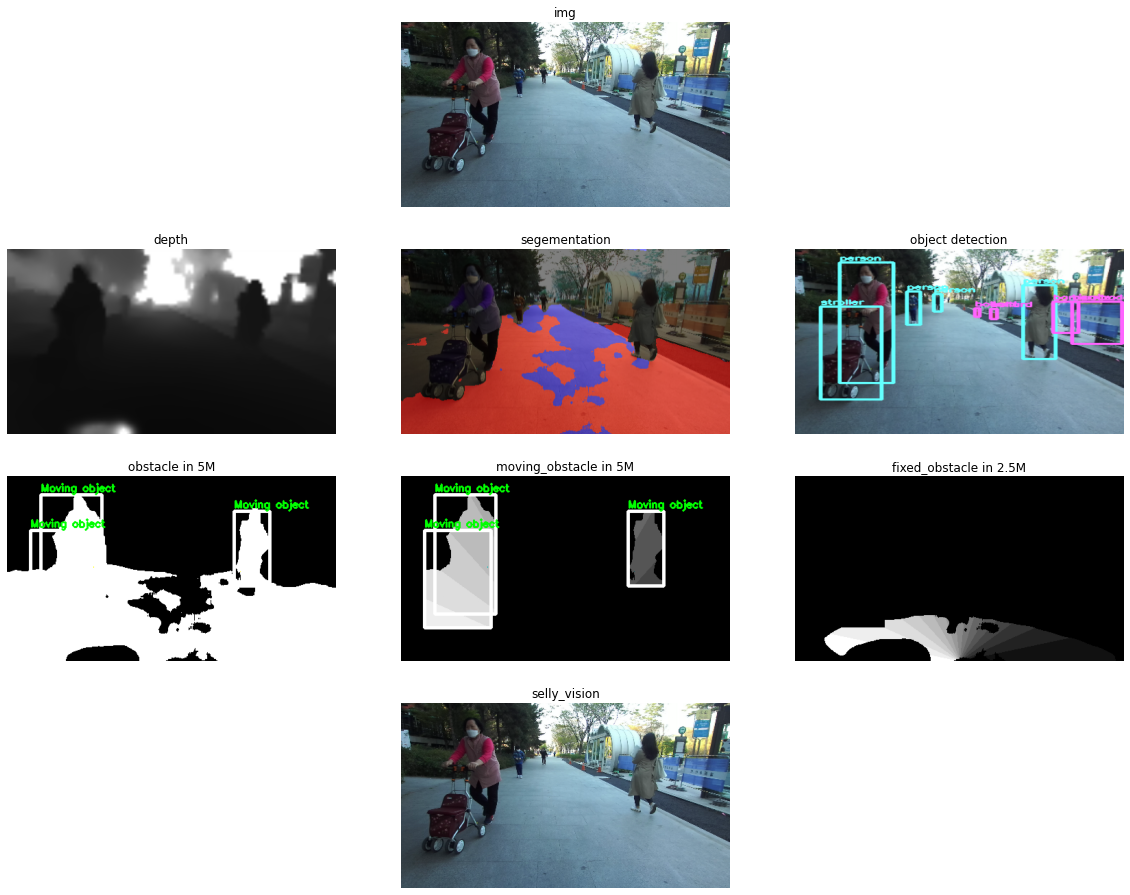

In [76]:
i = 144
visualize(model, img[i], point_cloud[i], 5, 2.5, ANGLE, ANGLE_CLASS)

In [4]:
i = 141
start = time.time()
selly_vision_img(model, img[i], point_cloud[i], 5, 2.5, ANGLE, ANGLE_CLASS)/255
print(time.time() -start)

0.09402251243591309


In [15]:
obj_frame, moving_object, _  = YOLO(img[144])


In [43]:
np.mean(moving_object[3], axis=0)

array([207. ,  77.5])

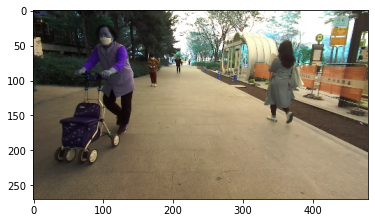

In [12]:
depth = point_cloud[144].copy()
plt.imshow(img[144]/255)

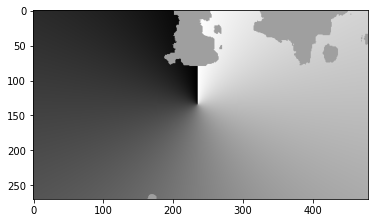

In [73]:
for i in range(270):
    for j in range(480):
        depth[i,j] = angle_value((point_cloud[144][i,j,:2][1],point_cloud[144][i,j,:2][0]), (0,0)) +90
plt.imshow(depth/360)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


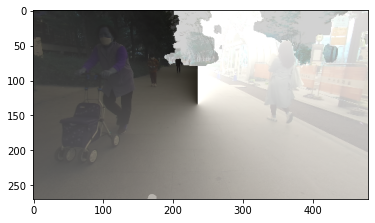

In [84]:
plt.imshow(img[144]/255/5+ depth/360)

In [83]:
depth[85,172][0] - 180

-127.85491561889648

In [78]:
depth[107, 103][0] - 180

78.40838

In [81]:
depth[106, 355][0] - 180

103.20687866210938

In [82]:
depth[77, 207][0] - 180

-153.72754669189453

In [68]:
depth[0,479]

array([298.8148, 298.8148, 298.8148], dtype=float32)

In [67]:
depth[0,0]

array([60.306786, 60.306786, 60.306786], dtype=float32)

0.39355921745300293
0.205125093460083
0.2634131908416748
0.2243669033050537
0.21642160415649414
0.23390960693359375


KeyboardInterrupt: 

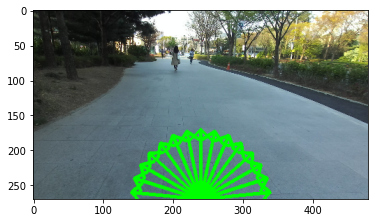

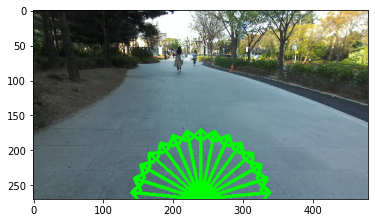

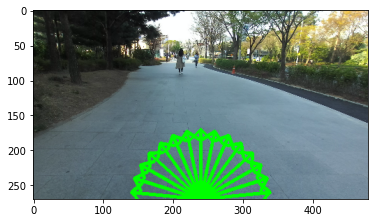

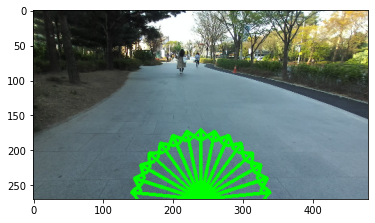

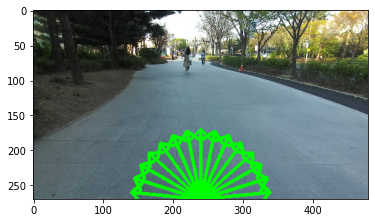

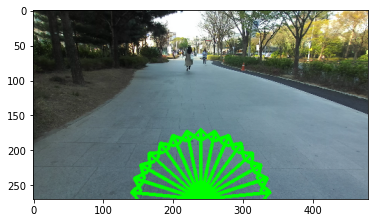

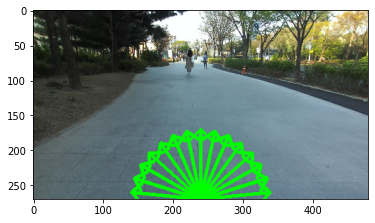

In [240]:
for i in range(500, 1101):
    start = time.time()
    plt.figure()
    plt.imshow(RGB(selly_vision_img(model, img[i], point_cloud[i], 5, 2.5, ANGLE, ANGLE_CLASS))/255)
    plt.savefig('selly_vision_video/image_at_epoch_{:04d}.png'.format(i))
    print(time.time() -start)

In [ ]:
#동영상 녹화
import os 

vision_img_list = os.listdir("selly_vision_video/")

max_dist = 5
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('selly_vision2.mp4', fourcc, 10.0, (480, 270))
vision_img_list.sort()
for idx in range(1101):
    start_time = time.time()
    vision_img = cv2.imread("selly_vision_video/"+vision_img_list[idx])
    out.write(vision_img)
    print(time.time()-start_time)
    
out.release()

In [ ]:
out.release()
